In [2]:
from math import cos, sin, pi
from random import randint
from typing import Callable, List, NamedTuple, Sequence
from pathlib import Path
#--- middle point ---#
from math import acos, cos, sin, sqrt


import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
import numpy as np
from numpy.linalg import norm
import plotly.graph_objects as go

from src.chaos_game import (
    get_polygon,
    proceed_euc,
    proceed_sphere,
    proj_plane,
    stereoG3D,
    get_angle,
    get_random_selector,
    create_game,
    plot_game,
    PointConfig,
)

point_configs = {
    'fixed': PointConfig(size=20, color='black'),
    'initial': PointConfig(size=20, color='red'),
    'moving': PointConfig(size=1, color='green')
}

data_dir = Path('data')
if not data_dir.exists():
    data_dir.mkdir(exist_ok=True)

# Hyperbolic Geometry

In [3]:
def complexify(points2D):
    return np.array([complex(*p) for p in points2D])

def vectorise(complexes):
    return np.array([[p.real, p.imag] for p in complexes])

def moebius(m, z):
    w_ = np.matmul(m, np.array([z , 1]))
    if w_[1] == 0:
        return np.inf
    return w_[0] / w_[1]

def adj(m):
    return np.array([[m[1,1], -m[0,1]],[-m[1,0], m[0,0]]])

def inversion(z, c, r):
    z_ = z - c
    # if z_ == [0, 0]:
    if not z_.any():
        return np.inf
    return r * z_ / np.linalg.norm(z_)**2 + c

def inversion0(z):
    return inversion(z, 0, 1)
    
M = np.array([[1, 1j],[1j, 1]])
adj(M)

array([[ 1.+0.j, -0.-1.j],
       [-0.-1.j,  1.+0.j]])

In [4]:
from collections import namedtuple

CanonicalCircleBase = namedtuple("CanonicalCircleBase", ["c", "r"])

class CanonicalCircle(CanonicalCircleBase):
    def __new__(cls,
                 c: complex,
                 r: float,
                ):
        if r < 0:
            raise ValueError(f"r = {r} < 0")
        self = super(CanonicalCircle, cls).__new__(cls, c, r)
        return self

CirclineBase = namedtuple("CirclineBase", ["c00", "c01", "c11"])

class Circline(CirclineBase):
    def __new__(cls,
        c00: float,
        c01: complex,
        c11: float,
      ):
        if c00 * c11 - abs(c01) > 0:
            raise ValueError(f"c00 * c11 - abs(c01) = {c00 * c11 - abs(c01)}< 0")
        self = super(Circline, cls).__new__(cls, c00, c01, c11)
        return self
    
    @property
    def is_line(self):
        return self.c00 == 0

    @property
    def r(self):
        if self.is_line:
            return np.inf
        return (abs(self.c01) - self.c00 * self.c11)/self.c00**2


circ = Circline(1, 0, -1)
print(circ, circ.is_line, circ.r)
circle = CanonicalCircle(1+1j, 1)
print(circle)

Circline(c00=1, c01=0, c11=-1) False 1.0
CanonicalCircle(c=(1+1j), r=1)


d=41.81031489577862
p1_=[-0.89442719 -0.4472136 ]
cross2D(c_, p1_)=0.4472135954999581
cross2D(c_, p2_)=-0.4472135954999581
np.dot(c_, p1_)=0.8944271909999157, np.dot(c_, p2_)=0.8944271909999157
theta1=26.565051177078008, theta2=-26.565051177078008
[1.5 0. ] 1.1180339887498945 [-1. -0.] [-0.89442719 -0.4472136 ] 0.4636476090008064 -26.565051177078008 26.565051177078008


(-5.0, 5.0)

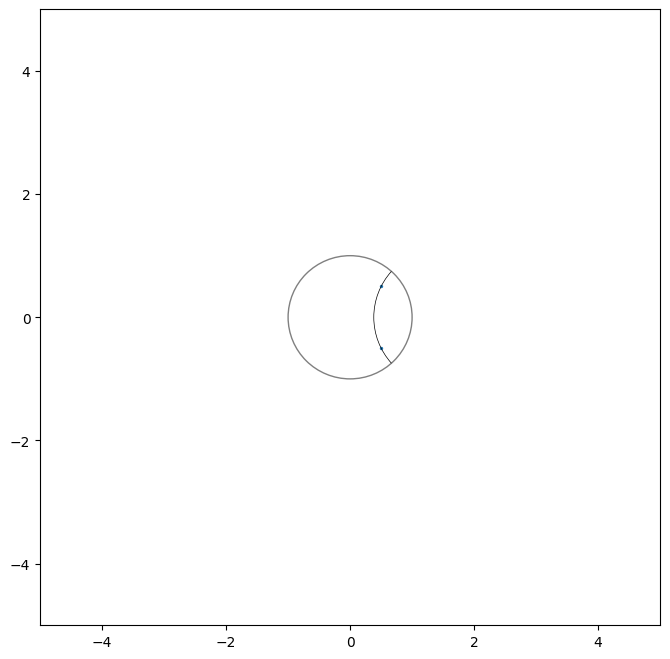

In [5]:
from math import pi, asin, atan2, log, exp

epsilon = 1e-6

def get_equidistant(p1, p2):
    n = np.array(p1 - p2)
    n /= np.linalg.norm(n)
    d = np.dot(n, (p1 + p2)/2)
    return n, d

def get_intersection(n1, d1, n2, d2):
    m = np.array([n1, n2])
    return np.matmul(np.linalg.inv(m), [d1, d2])

def to_deg(rad):
    return 180 * rad/pi

def normalise(v):
    return v/ np.linalg.norm(v)

def cross2D(a, b):
    points = []
    for z in [a, b]:
        if type(z) == complex:
            z = (z.real, z.imag)
        points.append(z)
    # print(f"points={points}")
    # print(f"cross2D={points[0][0] * points[1][1] - points[0][1] * points[1][0]}")
    return points[0][0] * points[1][1] - points[0][1] * points[1][0]

def sign(n):
    if n == 0:
        return 0
    return n / abs(n)

def get_circle_can(p1, p2, p3):
    # if abs(cross2D(p1 - p3, p2 - p3)) < 1e-9:
    #     raise ValueError(f"p1={p1}, p2={p2}, p3={p3}, abs(cross2D(p1 - p3, p2 - p3))={abs(cross2D(p1 - p3, p2 - p3))}")
    n1, d1 = get_equidistant(p1, p2)
    n2, d2 = get_equidistant(p3, p1)
    c = get_intersection(n1, d1, n2, d2)
    r = norm(p1 - c)
    return c, r


def draw_line(ax, p1, p2):
    if abs(cross2D(p1, p2)) < epsilon:
        xs, ys = np.array(points).transpose()
        ax.plot(xs, ys, linewidth=1)
    else:
        p3 = inversion0(p1)
        c, r = get_circle_can(p1, p2, p3)
        circ_can = CanonicalCircle(c=complex(*c), r=r)
        d = to_deg(asin(1/norm(c)))
        print(f"d={d}")
        c_ = - normalise(c)
        p1_ = (p1-c)/r
        print(f"p1_={p1_}")
        print(f"cross2D(c_, p1_)={cross2D(c_, p1_)}")
        sign1 = sign(cross2D(c_, p1_))
        p2_ = (p2-c)/r
        print(f"cross2D(c_, p2_)={cross2D(c_, p2_)}")
        sign2 = sign(cross2D(c_, p2_))
        print(f"np.dot(c_, p1_)={np.dot(c_, p1_)}, np.dot(c_, p2_)={np.dot(c_, p2_)}")
        theta1 = sign1 * to_deg(acos(np.dot(c_, p1_)))
        theta2 = sign2 * to_deg(acos(np.dot(c_, p2_)))
        print(f"theta1={theta1}, theta2={theta2}")
        theta1, theta2 = sorted([theta1, theta2])
        print(c, r, c_, (p1-c)/r, acos(np.dot((p1-c)/r, -c/norm(c))), theta1, theta2)
        init_angle = to_deg(atan2(c[1], c[0])) + 180 - d
        # init_angle = to_deg(atan2(c[1], c[0])) + 180
        diameter = 2 * r
        # arc = matplotlib.patches.Arc(
        #     c,
        #     height=diameter,
        #     width=diameter,
        #     angle=init_angle,
        #     # theta2=2*d,
        #     theta1=theta1,
        #     theta2=theta2,
        #     lw=0.5,
        #     fill=False,
        #     color='black',
        # )
        arc = matplotlib.patches.Arc(
            c,
            height=diameter,
            width=diameter,
            angle=init_angle,
            theta2=2*d,
            # theta1=theta1,
            # theta2=theta2,
            lw=0.5,
            fill=False,
            color='black',
        )
        ax.add_patch(arc)
    



figsize = (8,8)
fig, ax = plt.subplots(figsize=figsize)
circ = plt.Circle([0,0], radius=1, fill=False, color='grey')
ax.add_patch(circ)
p1 = np.array([0.5,-0.5])
p2 = np.array([0.5,0.5])

points = np.array([p1, p2])
xs, ys = points.transpose()
ax.scatter(xs, ys, s=2)
draw_line(ax, p1, p2)
w = 5
ax.set_xlim(xmin=-w, xmax=w)
ax.set_ylim(ymin=-w, ymax=w)

In [6]:
def proceed_hyp(p1, p2, ratio):
    points = np.array([p1, p2])
    if abs(cross2D(p1, p2)) < epsilon:
        theta = (pi/2 -  atan2(p1[1], p1[0]))
    else:
        c, r = get_circle_can(p1, p2, inversion0(p1))
        theta = (pi/2 - (acos(1/norm(c)) + atan2(c[1], c[0])))
    # print(f"c={c}, acos(1/norm(c))={to_deg(acos(1/norm(c)))}, atan2(c[1], c[0])={atan2(c[1], c[0])}, theta={to_deg(theta)}")
    rotation = complex(cos(theta), sin(theta))
    # print(f"rotation={rotation}")
    
    points = vectorise(rotation * complexify(points))
    # xs, ys = points.transpose()
    # print(xs, ys)
    # ax.scatter(xs, ys, s=2, color='green')
    # p1, p2 = points
    # draw_line(ax, p1, p2)

    complex_points = complexify(points)
    # complex_points = complexify(points)
    # print(f"Before: complex_points={complex_points}")
    complex_points = [moebius(M, z) for z in complex_points]
    # print(f"After: complex_points={complex_points}")
    # xs, ys = vectorise(complex_points).transpose()
    # ax.scatter(xs, ys, s=2, color='purple')
    z1, z2 = complex_points
    # print(f"z1.imag, z2.imag={z1.imag, z2.imag}")
    # print(log(z1.imag), log(z2.imag))
    z3 = complex(z1.real, exp((1-ratio)*log(z1.imag) + ratio*log(z2.imag)))
    z3 =  rotation.conjugate() * moebius(np.linalg.inv(M), z3)
    return z3.real, z3.imag


(-3.0, 3.0)

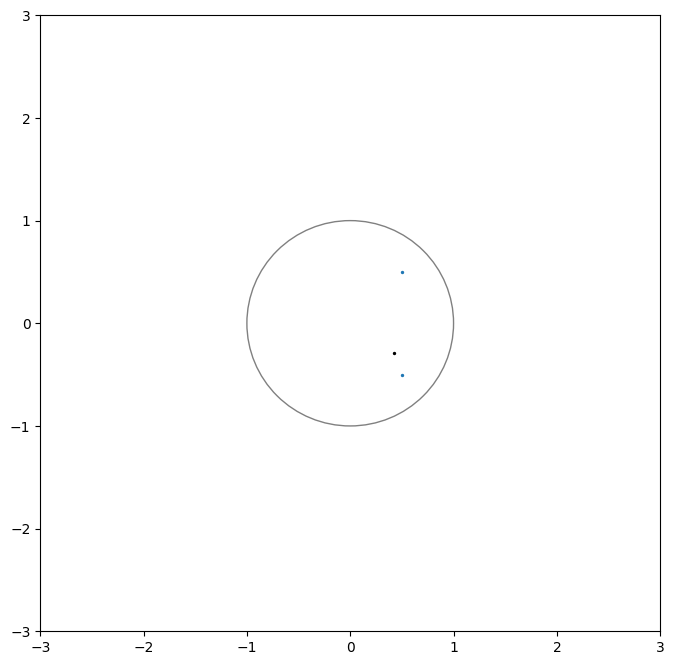

In [7]:


figsize = (8,8)
fig, ax = plt.subplots(figsize=figsize)

p1 = np.array([0.0,-1.0])
p2 = np.array([0.0, 1.0])


points = np.array([p1, p2])
# xs, ys = points.transpose()
# print(f"xs={xs}, ys={ys}")
# ax.plot(xs, ys, color='grey')

circ = plt.Circle([0,0], radius=1, fill=False, color='grey')
ax.add_patch(circ)
# p1 = np.array([-cos(pi/6) + 1.0, -sin(pi/6) + 1.0])
# p1 = np.array([-cos(pi/4) + 1.0, -sin(pi/4) + 1.0])
# p1 = np.array([-cos(pi*5/12) + 1.0, -sin(pi*5/12) + 1.0])
# p2 = np.array([-cos(pi/3) + 1.0, -sin(pi/3) + 1.0])
# p2 = np.array([-cos(pi/4) + 1.0, -sin(pi/4) + 1.0])

p1 = np.array([0.5,-0.5])
p2 = np.array([0.5,0.5])


points = np.array([p1, p2])
xs, ys = points.transpose()
ax.scatter(xs, ys, s=2)
# draw_line(ax, p1, p2)

ratio = 1/4
z4 = proceed_hyp(p1, p2, ratio)
# ax.scatter([z4.real], [z4.imag], s=2, color='black')
ax.scatter([z4[0]], [z4[1]], s=2, color='black')

w = 3
ax.set_xlim(xmin=-w, xmax=w)
ax.set_ylim(ymin=-w, ymax=w)

In [30]:
p = 3
start = np.array([0.5, 0.5])
ratio = 0.7
rounds = 10000
figsize = (8, 8)

fixed_points = 0.9 * np.array(get_polygon(p))
selector = get_random_selector(len(fixed_points))
# Plot fixed points first
game = create_game(
    start=start,
    proceed_func=proceed_hyp,
    fixed_points=fixed_points,
    selector=selector,
    ratio=ratio,
    rounds=rounds,
    )

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 20483.44it/s]


Text(0.5, 0.98, 'Chaos game on Poincar$\\acute{\\text{e}}$ Disk:\\n')

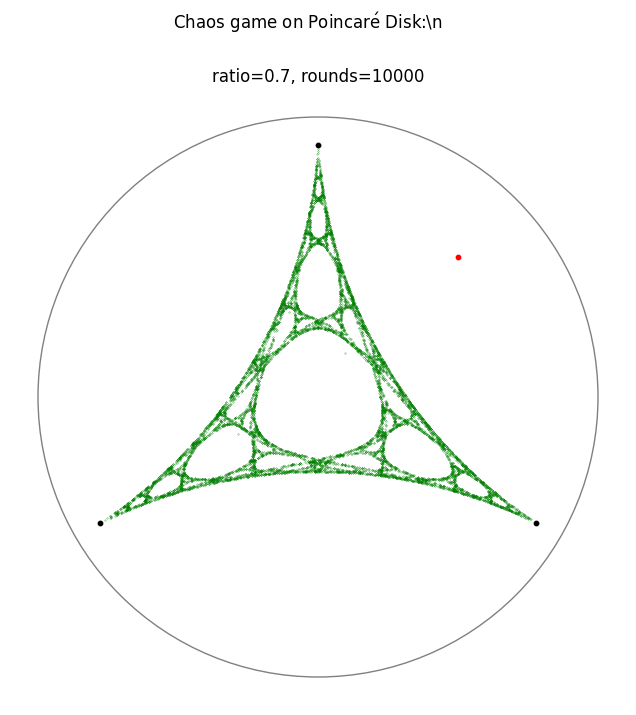

In [31]:
fig, ax = plt.subplots(figsize=figsize)

point_configs = {
    'fixed': PointConfig(size=10, color='black'),
    'initial': PointConfig(size=10, color='red'),
    'moving': PointConfig(size=0.05, color='green')
}

circ = plt.Circle([0,0], radius=1, fill=False, color='grey')
ax.add_patch(circ)

plot_game(ax, game,
         point_configs=point_configs)
#--- text to show ---#
title = r"Chaos game on Poincar$\acute{\text{e}}$ Disk:\n"
plt.suptitle(title)

100%|██████████████████████████████████| 20000/20000 [00:01<00:00, 19280.34it/s]


Text(0.5, 0.98, 'Chaos game on Poincare Disk:\n')

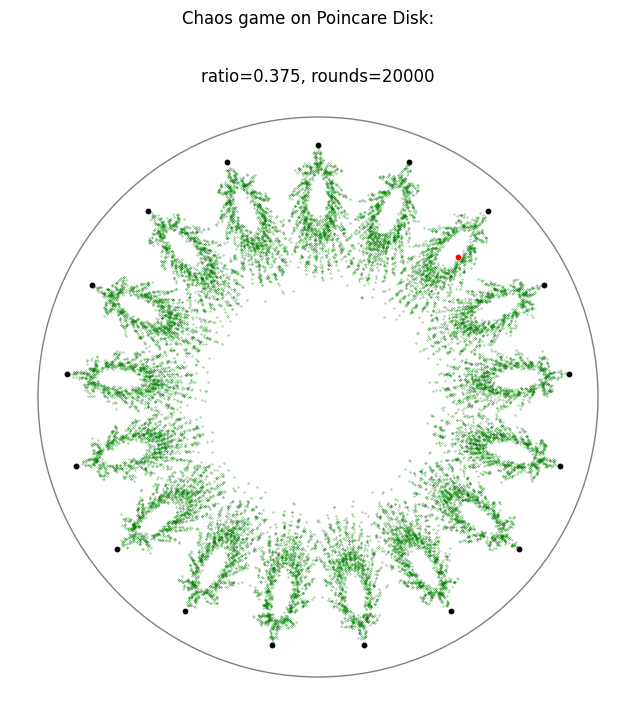

In [21]:
p = 17
start = np.array([0.5, 0.5])
ratio = 0.375
rounds = 20000
figsize = (8, 8)

fixed_points = 0.9 * np.array(get_polygon(p))
selector = get_random_selector(len(fixed_points))
# Plot fixed points first
game = create_game(
    start=start,
    proceed_func=proceed_hyp,
    fixed_points=fixed_points,
    selector=selector,
    ratio=ratio,
    rounds=rounds,
    )

fig, ax = plt.subplots(figsize=figsize)

point_configs = {
    'fixed': PointConfig(size=10, color='black'),
    'initial': PointConfig(size=10, color='red'),
    'moving': PointConfig(size=0.05, color='green')
}

circ = plt.Circle([0,0], radius=1, fill=False, color='grey')
ax.add_patch(circ)

plot_game(ax, game,
         point_configs=point_configs)
#--- text to show ---#
title = "Chaos game on Poincare Disk:\n"
plt.suptitle(title)

d=29.732160951822426
p1_=[ 0.62318528 -0.78207423]
cross2D(c_, p1_)=0.07434174006937838
cross2D(c_, p2_)=-0.07434174006937827
np.dot(c_, p1_)=0.9972328242108044, np.dot(c_, p2_)=0.9972328242108046
theta1=4.26340120043902, theta2=-4.263401200438849
[-1.1358492  1.6659848] 1.750902273928385 [ 0.56332006 -0.82623877] [ 0.62318528 -0.78207423] 0.07441038828113962 -4.263401200438849 4.26340120043902
d=29.732160951822408
p1_=[-0.22290059 -0.97484118]
cross2D(c_, p1_)=0.07434174006937833
cross2D(c_, p2_)=-0.07434174006937827
np.dot(c_, p1_)=0.9972328242108043, np.dot(c_, p2_)=0.9972328242108042
theta1=4.263401200439105, theta2=-4.2634012004391915
[0.59432897 1.9267672 ] 1.7509022739283857 [-0.29475517 -0.95557281] [-0.22290059 -0.97484118] 0.0744103882811411 -4.2634012004391915 4.263401200439105
d=29.732160951822408
p1_=[-0.90113777 -0.43353284]
cross2D(c_, p1_)=0.07434174006937827
cross2D(c_, p2_)=-0.07434174006937827
np.dot(c_, p1_)=0.9972328242108044, np.dot(c_, p2_)=0.9972328242108044
the

(-1.0, 1.0)

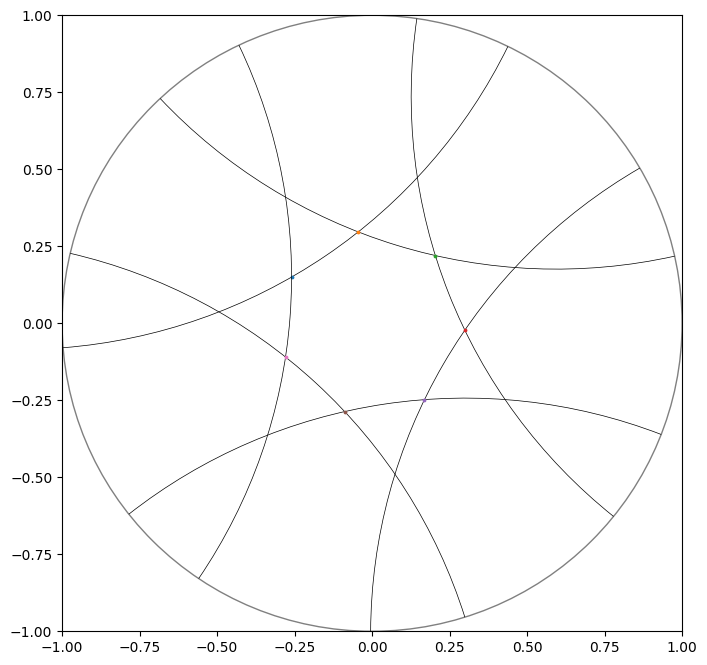

In [9]:
from itertools import pairwise
p = 7
r = 0.3
fixed_points = r * np.array(get_polygon(p))
fixed_points = np.concat([fixed_points, fixed_points[:1]])

complex_points = complexify(fixed_points)
z = complex(cos(pi/3), sin(pi/3))
fixed_points = vectorise(z * complex_points)

figsize = (8,8)
fig, ax = plt.subplots(figsize=figsize)
circ = plt.Circle([0,0], radius=1, fill=False, color='grey')
ax.add_patch(circ)

for p1, p2 in pairwise(fixed_points):
    draw_line(ax, p2, p1)
    points = np.array([p1])
    xs, ys = points.transpose()
    ax.scatter(xs, ys, s=3)
w = 1
ax.set_xlim(xmin=-w, xmax=w)
ax.set_ylim(ymin=-w, ymax=w)

In [10]:
proceed_hyp([0.1, 0.1], [0.5, 0.5], 0.5)

(np.float64(0.33333333333333326), np.float64(0.3333333333333333))

In [11]:
# with open('test.npz', 'w') as fp:
np.savez('test.npz', **{"name": 'hoge'})
npzfile = np.load('test.npz')
npzfile['name']

array('hoge', dtype='<U4')

In [12]:
moebius(M, 0.99j)

np.complex128(198.99999999999983j)

In [13]:
np.cross([1,0], [0,1])

/tmp/ipykernel_8579/2672685629.py:1: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  np.cross([1,0], [0,1])


array(1)

In [14]:
def hoge():
    print(hoge)